In [164]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
data = pd.read_parquet("assets.parquet")

data = data.set_index(["monthid", "PERMNO"]).sort_index()

In [ ]:
def calculate_rolling_betas(stock_returns: pd.DataFrame, factor_returns: pd.DataFrame, lookback=36, min_periods=12):
    """Calculate rolling betas for each stock against each factor individually.

    Args:
        stock_returns (pd.DataFrame): _description_
        factor_returns (pd.DataFrame): _description_
        lookback (int, optional): _description_. Defaults to 36.
        min_periods (int, optional): _description_. Defaults to 12.

    Returns:
        _type_: _description_
    """
    assert (stock_returns.index == factor_returns.index).all()

    betas = {}

    rolling_returns = returns.rolling(lookback, min_periods=min_periods)  # returns in shape (rows=monthid, cols=stock)

    for f in factor_returns:
        print(f"Computing exposures for {f}...")

        factor_return_series = factor_returns[f]

        # beta = cov(stock_return, factor_return) / factor_return.var()
        rolling_cov = rolling_returns.cov(factor_return_series)
        rolling_betas = rolling_cov.div(factor_return_series.rolling(lookback, min_periods=min_periods).var(), axis=0)
        betas[f] = rolling_betas.stack()
    
    print(f"Completed all regressions, joining results")
    all_betas = pd.concat(betas.values(), axis=1)
    all_betas.columns = betas.keys() 
    return all_betas

In [271]:
from typing import List, Dict, Any, Tuple
from sklearn.metrics import r2_score, mean_squared_error

class Model:
    def __init__(self, data: pd.DataFrame, feature_cols: List[str], objective_col: str, val_pct=0.2, test_pct=0.2):
        """
        data must be indexed by [monthid, permno] and be cleaned with no NaNs

        val_pct and test_pct are the percent of data to split. By default, do 60/20/20 train/val/test split
        """
        self.data = data
        self.feature_cols = feature_cols
        self.objective_col = objective_col

        # Save trained models
        self.model_params: Dict[str, Tuple[Dict, float, float]] = {}  # model ID -> (best_params, MAE, R2)
        self.final_trained_models: Dict[str, Any] = {}  # model ID -> trained model using combined training + validation data
        
        # Split data into training and testing. The training data is further split into disjoint train and validation set.
        self.x_train = None
        self.y_train = None
        self.x_validate = None  # Use if hyperparameter tuning
        self.y_validate = None  # Use if hyperparameter tuning
        self.x_test = None
        self.y_test = None
        self.x_train_val_combined = None  # For training full model (after hyperparameter tuning)
        self.y_train_val_combined = None  # For training full model (after hyperparameter tuning)
        
        self.split_data(val_pct, test_pct)

    def split_data(self, val_pct=0.2, test_pct=0.2):
        # split data by month to avoid having cases where part of a date is in train and part of it is in test set
        dates = self.data.index.get_level_values(0).unique().sort_values()
        n = len(dates)

        train_monthids, validate_monthids, test_monthids = np.split(dates, [int((1-test_pct-val_pct)*n), int((1-test_pct)*n)])

        x = self.data[self.feature_cols]
        y = self.data[[self.objective_col]]

        self.x_train = x.loc[train_monthids]
        self.y_train = y.loc[train_monthids]
        self.x_validate = x.loc[validate_monthids]
        self.y_validate = y.loc[validate_monthids]
        self.x_test = x.loc[test_monthids]
        self.y_test = y.loc[test_monthids]

        # Combined training + validation set used to train the final model after hyperparameter tuning
        train_plus_val_monthids = list(train_monthids) + list(validate_monthids)
        self.x_train_val_combined = x.loc[train_plus_val_monthids]
        self.y_train_val_combined = y.loc[train_plus_val_monthids]

    # Perform hyperparameter tuning and save results
    # If we don't want to hyperparameter tune, set every parameter in the param_grid to be a single value only.
    def add_model_and_hyperparameter_tune(self, model_type, param_grid, model_name, ):
        x_train, y_train, x_validate, y_validate = self.x_train, self.y_train, self.x_validate, self.y_validate

        # Special case for LinearRegression because it doesn't have hyperparameters to tune
        if model_type == LinearRegression:
            model = LinearRegression()
            model.fit(x_train, y_train)
            pred = model.predict(x_validate)
            
            MAE = mean_squared_error(y_validate,pred)
            r2 = r2_score(y_validate, pred)
            
            # Save results of best model (for linreg, there is only one)
            output = ({}, MAE, r2)
            self.model_params[model_name] = output
            
            return output

        else: # The other cases
            
            # Establishses the ParameterGrid
            model_param_grid = ParameterGrid(param_grid)
            
            # Initialize values
            best_MAE = 0
            best_r2 = 1
            best_config = None
            # Iterate through the parameter grid, fit models to the hyperparameters
            # and check for MAE and R2 values
            
            # each param_config in that validation function would represent 1 combination of the possible parameters.
            # for example in Lab 6, when I'm validating for the elastic net regression, I have 
            # 2 possible hyperparameters: alpha and l1_ratio. 
            #alpha can take on values 0.0001, 0.0005, etc, and l1_ratio can take on values 0, 1, 0.01. 
            #So each param_config in the for loop in validate_model would go over 1 possible 
            #combination of the hyperparameter and keep the one that gives us the best MAE/R2
            for param_config in model_param_grid:
                curr_config_MAEs = []
                model = model_type(**param_config)
                model.fit(x_train, y_train)
                pred = model.predict(x_validate)
                MAE = mean_squared_error(y_validate,pred)
                r2 = r2_score(y_validate, pred)
                curr_config_MAEs.append(MAE)
                if best_MAE == 0 or (MAE < best_MAE):
                    best_MAE = MAE
                    best_config = param_config
                if best_r2 == 1 or (r2 > best_r2):
                    best_r2 = r2

            # Save results of best model
            output = (best_config, best_MAE, best_r2)
            self.model_params[model_name] = output

            return output

# Import and Prep Data

In [272]:
# data = pd.read_csv("assets.zip")
data = pd.read_parquet("assets.parquet")

## Generate 36 Month Rolling Betas

In [273]:
returns = data[["RET", "monthid", "PERMNO"]].pivot_table(values="RET", index="monthid", columns="PERMNO")

factors = data.drop_duplicates(subset=["DATEFF"]).drop(columns=["PERMNO", "RET", "DATEFF", "RF"]).set_index("monthid")

rolling_betas = calculate_rolling_betas(returns, factors, lookback=36, min_periods=12)

Computing exposures for SMB...
Computing exposures for HML...
Computing exposures for MKTRF...
Computing exposures for UMD...
Computing exposures for epq1...
Computing exposures for ioca...
Computing exposures for ra26...
Computing exposures for e11...
Computing exposures for Abr1...
Computing exposures for Re1...
Computing exposures for dRoe1...
Computing exposures for dRoa1...
Computing exposures for rnaq1...
Computing exposures for atoq1...
Computing exposures for dNoa...
Computing exposures for Nsi...
Computing exposures for dNca...
Computing exposures for dFnl...
Completed all regressions, joining results


## Winsorize and Scale

In [274]:
# TODO: winsorize betas grouped by industry?

In [275]:
# Functions to winsorize and scale
def winsorize(group):
    return group.clip(lower = group.mean() - 3 * group.std(), upper = group.mean() + 3 * group.std(), axis = 1)

import warnings
def min_max_scale(group):
    # ignore annoying NaN warnings, we will deal with all NaN groups later
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        scaler = sklearn.preprocessing.MinMaxScaler()
        scaled_data = scaler.fit_transform(group)
    return pd.DataFrame(scaled_data, index=group.index, columns=group.columns)

In [276]:
# Group by date, then winsorize at +/- 3 std and scale betas to range [0, 1]
winsorized_betas = rolling_betas.groupby(level=0).apply(winsorize)
scaled_betas = winsorized_betas.groupby(level=0).apply(min_max_scale)
scaled_betas.head()

C:\Users\hughj\AppData\Local\Temp\ipykernel_7612\2073397749.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  winsorized_betas = rolling_betas.groupby(level=0).apply(winsorize)
C:\Users\hughj\AppData\Local\Temp\ipykernel_7612\2073397749.py:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  scale

SMB       HML     MKTRF       UMD      epq1      ioca  \
monthid PERMNO                                                               
12      10006   0.607605  0.466640  0.480544  0.440133  0.463581  0.520863   
        10102   0.654231  0.627372  0.620302  0.389205  0.426310  0.487134   
        10137   0.644685  0.586626  0.573816  0.356160  0.323200  0.171756   
        10145   0.453698  0.459381  0.468807  0.542577  0.616247  0.646850   
        10161   0.512784  0.516376  0.490788  0.510737  0.374455  0.493299   

                ra26  e11      Abr1  Re1  dRoe1  dRoa1  rnaq1  atoq1  \
monthid PERMNO                                                         
12      10006    NaN  NaN  0.475550  NaN    NaN    NaN    NaN    NaN   
        10102    NaN  NaN  0.788223  NaN    NaN    NaN    NaN    NaN   
        10137    NaN  NaN  0.517679  NaN    NaN    NaN    NaN    NaN   
        10145    NaN  NaN  0.495142  NaN    NaN    NaN    NaN    NaN   
        10161    NaN  NaN  0.519969  NaN    NaN    NaN    NaN    NaN   

                    dNoa       Nsi      dNca      dFnl  
monthid PERMNO                                          
12      10006   0.470512  0.482178  0.518266  0.700591  
        10102   0.440364  0.500017  0.330896  0.230491  
        10137   0.316775  0.298236  0.408968  0.667801  
        10145   0.539125  0.611531  0.523995  0.505022  
        10161   0.585069  0.526608  0.579127  0.454729

In [116]:
scaled_betas.describe()

,SMB,HML,MKTRF,UMD,epq1,ioca,ra26,e11,Abr1,Re1,dRoe1,dRoa1,rnaq1,atoq1,dNoa,Nsi,dNca,dFnl
count,1.340635e+06,1.340635e+06,1.340635e+06,1.340635e+06,1.340635e+06,1.340635e+06,1.286375e+06,1.289470e+06,1.340635e+06,1.328539e+06,1.332180e+06,1.332180e+06,1.337764e+06,1.337764e+06,1.340635e+06,1.340635e+06,1.340635e+06,1.340635e+06
mean,4.900715e-01,5.112008e-01,4.899445e-01,5.010351e-01,4.918271e-01,4.838314e-01,4.971951e-01,5.007852e-01,4.994345e-01,5.007005e-01,5.036672e-01,5.033757e-01,5.092302e-01,4.992068e-01,4.989690e-01,4.833737e-01,5.040550e-01,5.029476e-01
std,1.577705e-01,1.604359e-01,1.614301e-01,1.542526e-01,1.571787e-01,1.596705e-01,1.518489e-01,1.540600e-01,1.529096e-01,1.545828e-01,1.540743e-01,1.546191e-01,1.569553e-01,1.540758e-01,1.533865e-01,1.630969e-01,1.547049e-01,1.510271e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.853664e-01,4.228469e-01,3.816481e-01,4.177876e-01,3.928558e-01,3.807856e-01,4.133900e-01,4.213780e-01,4.186882e-01,4.216234e-01,4.257345e-01,4.248782e-01,4.285357e-01,4.066574e-01,4.140443e-01,3.759971e-01,4.267783e-01,4.268305e-01
50%,4.684433e-01,5.225776e-01,4.724302e-01,5.049140e-01,4.755341e-01,4.608844e-01,4.931376e-01,5.116680e-01,4.973118e-01,5.089921e-01,5.160373e-01,5.146108e-01,5.223062e-01,4.907846e-01,4.954475e-01,4.639161e-01,5.218891e-01,5.135352e-01
75%,5.717400e-01,6.132896e-01,5.759318e-01,5.902723e-01,5.753356e-01,5.618383e-01,5.756187e-01,5.920884e-01,5.784935e-01,5.878604e-01,5.952848e-01,5.948675e-01,6.037343e-01,5.820668e-01,5.784685e-01,5.690805e-01,5.995860e-01,5.908705e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [269]:
# Add forward returns and excess return
rf = data.set_index("monthid")["RF"]
rf = rf[~rf.index.duplicated()]  # rf indexed by monthid

xret = returns.sub(rf, axis=0)

fwd_xret = xret.shift(-1).stack()
fwd_xret.name = "XRET_T1"

fwd_ret = returns.shift(-1).stack()
fwd_ret.name = "RET_T1"

ml_data = scaled_betas.merge(fwd_xret, how="left", left_index=True, right_index=True)
ml_data = ml_data.merge(fwd_ret, how="left", left_index=True, right_index=True)

In [277]:
# IGNORE: Try predict rank of future returns, rather than returns themselves
# ml_data["XRET_T1"] = ml_data[["XRET_T1"]].groupby(level=0).apply(lambda g: min_max_scale(g.rank()))

# ml_data = ml_data.groupby(level=0).apply(lambda g: min_max_scale(g.rank()))

## Clean NaN

In [261]:
# clean data of NaN
# TODO: instead of dropping everything, follow the steps below

# 1) Drop NaN values in XRET_T1
# 2) Group by date, fill each NaN factor value with the mean factor value on that date. 
# 3) Drop any rows that are still NaN, or just fill with 0

# 4) Drop any leftover rows with NaN
ml_data = ml_data.dropna()

In [262]:
ml_data

SMB       HML     MKTRF       UMD      epq1      ioca  \
monthid PERMNO                                                               
72      10006   0.481210  0.421067  0.472324  0.551370  0.473243  0.425169   
        10057   0.661411  0.550971  0.565879  0.450252  0.465425  0.393175   
        10137   0.288622  0.651531  0.157438  0.339198  0.264485  0.655579   
        10145   0.485372  0.445486  0.464842  0.553115  0.460272  0.402714   
        10153   0.524926  0.484201  0.321005  0.431906  0.307545  0.614707   
...                  ...       ...       ...       ...       ...       ...   
551     93397   0.506212  0.476224  0.468469  0.533715  0.521176  0.541256   
        93423   0.727562  0.669766  0.833719  0.302874  0.209875  0.414946   
        93426   0.610270  0.547955  0.582882  0.503365  0.452694  0.569677   
        93427   0.483015  0.443907  0.465595  0.556388  0.550820  0.461963   
        93436   0.384492  0.458879  0.736263  0.472341  0.498339  0.311426   

                    ra26       e11      Abr1       Re1     dRoe1     dRoa1  \
monthid PERMNO                                                               
72      10006   0.675746  0.587619  0.580283  0.589994  0.613232  0.595685   
        10057   0.777009  0.471179  0.433953  0.759216  0.372347  0.320167   
        10137   0.420901  0.303523  0.384140  0.347276  0.385793  0.406712   
        10145   0.393868  0.620174  0.594657  0.488806  0.593599  0.578652   
        10153   0.493576  0.314399  0.382347  0.489674  0.417074  0.396394   
...                  ...       ...       ...       ...       ...       ...   
551     93397   0.457414  0.541358  0.584853  0.536814  0.541158  0.512194   
        93423   0.725280  0.252051  0.519935  0.159957  0.183564  0.232747   
        93426   0.505782  0.541547  0.541945  0.485546  0.548949  0.467813   
        93427   0.532724  0.524796  0.620186  0.506074  0.579854  0.554173   
        93436   0.572540  0.462423  0.365934  0.245945  0.226024  0.205373   

                   rnaq1     atoq1      dNoa       Nsi      dNca      dFnl  \
monthid PERMNO                                                               
72      10006   0.590939  0.534599  0.543875  0.474310  0.557906  0.522810   
        10057   0.674387  0.881004  0.585589  0.392283  0.320647  0.279883   
        10137   0.325514  0.185417  0.291537  0.347182  0.635843  0.760333   
        10145   0.579936  0.539982  0.495959  0.435250  0.566855  0.492631   
        10153   0.412312  0.381823  0.470684  0.500654  0.454875  0.638341   
...                  ...       ...       ...       ...       ...       ...   
551     93397   0.521147  0.529511  0.538090  0.518185  0.560696  0.506528   
        93423   0.189393  0.529467  0.511833  0.439746  0.318728  0.726137   
        93426   0.462372  0.553100  0.448812  0.590500  0.433598  0.580987   
        93427   0.594167  0.669166  0.529414  0.659745  0.568805  0.522495   
        93436   0.186376  0.631323  0.246214  0.601138  0.308018  0.709251   

                 XRET_T1    RET_T1  
monthid PERMNO                      
72      10006   0.932353  0.108696  
        10057   0.506863 -0.009804  
        10137   0.618627  0.009091  
        10145   0.278431 -0.065421  
        10153   0.248039 -0.072165  
...                  ...       ...  
551     93397   0.801290  0.143199  
        93423   0.708988  0.109665  
        93426   0.571947  0.076239  
        93427   0.787586  0.135851  
        93436   0.934704  0.243252  

[1036471 rows x 20 columns]

In [263]:
model = Model(
    data=ml_data,
    feature_cols=['SMB', 'HML', 'MKTRF', 'UMD', 'epq1', 'ioca', 'ra26', 'e11', 'Abr1', 'Re1', 'dRoe1', 'dRoa1', 'rnaq1', 'atoq1', 'dNoa', 'Nsi', 'dNca', 'dFnl'],
    objective_col='XRET_T1'
)

In [171]:
# Initialize the dictionary for the parameter grid
en_grid = dict()
# Set the parameter grid
en_grid['alpha'] = [0.0001,0.0005,0.001,0.005, 0.01,0.05,0.1]
en_grid['l1_ratio'] = np.arange(0, 1, 0.01)

# Run the validation
en_best_config, en_best_MAE, en_best_r2 = model.validate_model(
    sklearn.linear_model.ElasticNet, 
    en_grid, 
    "ElasticNet"
)

print('Best Config' + str(en_best_config))
print('Validation R2: '+ str(en_best_r2))

c:\Users\hughj\anaconda3\envs\factor-modelling\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.543e+03, tolerance: 9.096e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\hughj\anaconda3\envs\factor-modelling\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.543e+03, tolerance: 9.096e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one

Best Config{'alpha': 0.01, 'l1_ratio': 0.0}
Validation R2: -0.0009815408164755013


In [264]:
actual_t1_returns = data.set_index(["monthid", "PERMNO"]).RET.sort_index()
actual_t1_returns

monthid  PERMNO
1        10006     0.231061
         10102     0.337349
         10137     0.333333
         10145     0.136564
         10161     0.215447
                     ...   
552      93397     0.143199
         93423     0.109665
         93426     0.076239
         93427     0.135851
         93436     0.243252
Name: RET, Length: 1242508, dtype: float64

## Final Data

In [278]:
ml_data.head()

SMB       HML     MKTRF       UMD      epq1      ioca  \
monthid PERMNO                                                               
12      10006   0.607605  0.466640  0.480544  0.440133  0.463581  0.520863   
        10102   0.654231  0.627372  0.620302  0.389205  0.426310  0.487134   
        10137   0.644685  0.586626  0.573816  0.356160  0.323200  0.171756   
        10145   0.453698  0.459381  0.468807  0.542577  0.616247  0.646850   
        10161   0.512784  0.516376  0.490788  0.510737  0.374455  0.493299   

                ra26  e11      Abr1  Re1  dRoe1  dRoa1  rnaq1  atoq1  \
monthid PERMNO                                                         
12      10006    NaN  NaN  0.475550  NaN    NaN    NaN    NaN    NaN   
        10102    NaN  NaN  0.788223  NaN    NaN    NaN    NaN    NaN   
        10137    NaN  NaN  0.517679  NaN    NaN    NaN    NaN    NaN   
        10145    NaN  NaN  0.495142  NaN    NaN    NaN    NaN    NaN   
        10161    NaN  NaN  0.519969  NaN    NaN    NaN    NaN    NaN   

                    dNoa       Nsi      dNca      dFnl   XRET_T1    RET_T1  
monthid PERMNO                                                              
12      10006   0.470512  0.482178  0.518266  0.700591  0.206339  0.211039  
        10102   0.440364  0.500017  0.330896  0.230491  0.193882  0.198582  
        10137   0.316775  0.298236  0.408968  0.667801  0.042597  0.047297  
        10145   0.539125  0.611531  0.523995  0.505022  0.235902  0.240602  
        10161   0.585069  0.526608  0.579127  0.454729  0.116993  0.121693

In [279]:
actual_t1_returns.head()

monthid  PERMNO
1        10006     0.231061
         10102     0.337349
         10137     0.333333
         10145     0.136564
         10161     0.215447
Name: ACTUAL_RET_T1, dtype: float64

In [280]:
rf.head()

monthid
1    0.0058
2    0.0043
3    0.0041
4    0.0044
5    0.0044
Name: RF, dtype: float64

# Run ML

In [265]:
import math
from sklearn.exceptions import NotFittedError

# Predictions
def pred(model, x_train, y_train, x_test, y_test):
    # Fit model and predict. If the model is already fitted, use the existing trained model.
    try:
        pred = model.predict(x_test)
        print(f"The provided model was already fit. Used the existing trained model.")
    except NotFittedError as e:
        print(f"Training Model...")
        model = model.fit(x_train, y_train)
        pred = model.predict(x_test)
    
    # Format prediction as DataFrame
    pred_df = pd.DataFrame(pred, columns = ['pred'])
    pred_df.set_index(x_test.index, inplace = True)
    
    r2 = r2_score(y_test, pred)
    return model, pred_df, r2

# Function to build the portfolio and calculate different performance metrics
def portfolio_build(df_pred: pd.DataFrame, model_name: str, actual_t1_returns: pd.Series, rf_month):
    """
    Params:
        df_pred: DataFrame indexed by [monthid, permno] with column "pred" for predicted T+1 returns
        model_name: Str cosmetic name
        actual_t1_returns: Series indexed by [monthid, permno] with actual T+1 returns
        rf_month: RF returns each month
    """
    actual_t1_returns.name = "ACTUAL_RET_T1"

    data = df_pred.merge(actual_t1_returns, how="left", left_index=True, right_index=True)
    
    # Initialize list of values
    long_short_lst = []
    value_lst = []

    portfolio_ret = []
    # index is monthid + 1, since these returns are for the start of the current period to end of next period, so month ending monthid+1
    index = []
    mth_grp = data.groupby('monthid')
    data['pred_rank'] = mth_grp["pred"].transform(lambda x: pd.qcut(x.rank(method="first"), 10, labels=False) if not np.isnan(x).all() else x)  # if statement in case all NaN
    for monthid, mdata in mth_grp:
      # TODO: can add value weighting of returns here if anyone needs it
      d1 = mdata[mdata['pred_rank'] == 0]['ACTUAL_RET_T1'].mean()
      d10 = mdata[mdata['pred_rank'] == 9]['ACTUAL_RET_T1'].mean()
      portfolio_ret.append(d10 - d1)
      index.append(monthid + 1)

    # Portfolio returns, indexed by monthid of the return end period
    ls_df = pd.DataFrame(portfolio_ret, index=index, columns=["ls_ret"])
    
    # Calculating cumulative returns
    # First we +1 to the returns 
    # Then we do the cumulative product
    ls_df['cumulative_ret']= ls_df['ls_ret'] + 1
    ls_df['cumulative_ret'] = ls_df['cumulative_ret'].cumprod()
    
    # Get mean/std/sharpe ratio for the portfolio
    ls_df = pd.merge(ls_df, rf_month, left_index = True, right_index = True)
    ls_df['ls_sub_rf'] = ls_df['ls_ret'] - ls_df['RF']
    ls_sub_rf_mean = ls_df['ls_sub_rf'].mean()*12
    ls_sub_rf_std = ls_df['ls_sub_rf'].std()*math.sqrt(12)
    sharpe_ratio = ls_sub_rf_mean/ls_sub_rf_std*math.sqrt(12)
    
    print("The annualized excess return "+ model_name + " long short portfolio is: " + str(ls_sub_rf_mean))
    print("The annualized std dev of returns of " + model_name + " long short portfolio is: " + str(ls_sub_rf_std))
    print("The anualized Sharpe ratio of " + model_name + " long short portfolio is: " + str(sharpe_ratio))
    
    return ls_df, ls_sub_rf_mean, ls_sub_rf_std, sharpe_ratio

In [266]:
en_model, en_pred, en_r2 = pred(
    sklearn.linear_model.ElasticNet(**en_best_config),
    model.x_train, 
    model.y_train, 
    model.x_validate,
    model.y_validate
)

The provided model is already fit. Using the existing trained model...
Training Model...


c:\Users\hughj\anaconda3\envs\factor-modelling\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.294e+04, tolerance: 4.594e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [267]:
portfolio_build(en_pred, "ElasticNet", actual_t1_returns, rf)

The annualized excess return ElasticNet long short portfolio is: -0.01039377257322055
The annualized std dev of returns of ElasticNet long short portfolio is: 0.36742737653612245
The anualized Sharpe ratio of ElasticNet long short portfolio is: -0.09799238341383655


(       ls_ret  cumulative_ret      RF  ls_sub_rf
 361  0.001350        1.001350  0.0016  -0.000250
 362  0.100016        1.101501  0.0016   0.098416
 363  0.032023        1.136774  0.0021   0.029923
 364  0.038029        1.180005  0.0021   0.035929
 365  0.012692        1.194982  0.0024   0.010292
 ..        ...             ...     ...        ...
 452 -0.003609        0.499968  0.0001  -0.003709
 453  0.037666        0.518800  0.0001   0.037566
 454  0.016230        0.527220  0.0001   0.016130
 455  0.111306        0.585903  0.0001   0.111206
 456  0.072593        0.628436  0.0001   0.072493
 
 [96 rows x 4 columns],
 -0.01039377257322055,
 0.36742737653612245,
 -0.09799238341383655)

In [268]:
slr_model, slr_pred, slr_r2 = pred(sklearn.linear_model.LinearRegression(),\
                                     model.x_train, model.y_train, model.x_validate, model.y_validate)

portfolio_build(slr_pred, "LinearRegression", actual_t1_returns, rf)

The provided model is already fit. Using the existing trained model...
Training Model...
The annualized excess return LinearRegression long short portfolio is: -0.042264999872432645
The annualized std dev of returns of LinearRegression long short portfolio is: 0.3853200475821964
The anualized Sharpe ratio of LinearRegression long short portfolio is: -0.37997050825822576


(       ls_ret  cumulative_ret      RF  ls_sub_rf
 361  0.005418        1.005418  0.0016   0.003818
 362  0.093806        1.099733  0.0016   0.092206
 363  0.072974        1.179985  0.0021   0.070874
 364  0.015727        1.198542  0.0021   0.013627
 365 -0.039687        1.150976  0.0024  -0.042087
 ..        ...             ...     ...        ...
 452 -0.034974        0.371542  0.0001  -0.035074
 453  0.044934        0.388237  0.0001   0.044834
 454 -0.009453        0.384567  0.0001  -0.009553
 455  0.074838        0.413347  0.0001   0.074738
 456  0.108460        0.458179  0.0001   0.108360
 
 [96 rows x 4 columns],
 -0.042264999872432645,
 0.3853200475821964,
 -0.37997050825822576)

In [249]:
from sklearn.ensemble import RandomForestRegressor

rf_model, rf_pred, rf_r2 = pred(RandomForestRegressor(n_estimators=50, max_depth=6, min_samples_leaf=25, max_features=0.7), model.x_train, model.y_train, model.x_test, model.y_test)
print(rf_r2)

C:\Users\hughj\AppData\Local\Temp\ipykernel_7612\1915965828.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = model.fit(x_train, y_train)


-0.000620901306292998


In [250]:
portfolio_build(rf_pred, "RandomForest", actual_t1_returns, rf)

The annualized excess return RandomForest long short portfolio is: 0.08012020202055489
The annualized std dev of returns of RandomForest long short portfolio is: 0.2902890264429537
The anualized Sharpe ratio of RandomForest long short portfolio is: 0.9560971857098746


(       ls_ret  cumulative_ret      RF  ls_sub_rf
 457  0.052577        1.052577  0.0000   0.052577
 458  0.066815        1.122905  0.0000   0.066815
 459 -0.004796        1.117520  0.0000  -0.004796
 460 -0.024485        1.090157  0.0000  -0.024485
 461  0.024999        1.117410  0.0000   0.024999
 ..        ...             ...     ...        ...
 548 -0.095728        1.038905  0.0001  -0.095828
 549  0.107176        1.150250  0.0001   0.107076
 550 -0.049063        1.093816  0.0001  -0.049163
 551  0.029916        1.126538  0.0001   0.029816
 552  0.291738        1.455191  0.0001   0.291638
 
 [96 rows x 4 columns],
 0.08012020202055489,
 0.2902890264429537,
 0.9560971857098746)

In [251]:
from sklearn.ensemble import GradientBoostingRegressor

gbm_model, gbm_pred, gbm_r2 = pred(GradientBoostingRegressor(n_estimators=20, learning_rate=0.1, min_samples_leaf=25, verbose=1, validation_fraction=0.1, n_iter_no_change=10), model.x_train, model.y_train, model.x_test, model.y_test)
print(gbm_r2)

c:\Users\hughj\anaconda3\envs\factor-modelling\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\hughj\anaconda3\envs\factor-modelling\lib\site-packages\sklearn\ensemble\_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


      Iter       Train Loss   Remaining Time 
         1           0.0165            1.86m
         2           0.0165            1.68m
         3           0.0165            1.53m
         4           0.0165            1.43m
         5           0.0165            1.35m
         6           0.0165            1.25m
         7           0.0165            1.15m
         8           0.0165            1.06m
         9           0.0165           57.85s
        10           0.0165           52.33s
-0.00012980128384976197


In [248]:
portfolio_build(gbm_pred, "GBM", actual_t1_returns, rf)

The annualized excess return GBM long short portfolio is: 0.03279279935364923
The annualized std dev of returns of GBM long short portfolio is: 0.2734008732513606
The anualized Sharpe ratio of GBM long short portfolio is: 0.4154982676351027


(       ls_ret  cumulative_ret      RF  ls_sub_rf
 457  0.053327        1.053327  0.0000   0.053327
 458  0.052502        1.108629  0.0000   0.052502
 459 -0.000896        1.107636  0.0000  -0.000896
 460 -0.026389        1.078406  0.0000  -0.026389
 461  0.028338        1.108966  0.0000   0.028338
 ..        ...             ...     ...        ...
 548 -0.066101        0.786470  0.0001  -0.066201
 549  0.083712        0.852307  0.0001   0.083612
 550 -0.049967        0.809720  0.0001  -0.050067
 551  0.027173        0.831722  0.0001   0.027073
 552  0.238513        1.030098  0.0001   0.238413
 
 [96 rows x 4 columns],
 0.03279279935364923,
 0.2734008732513606,
 0.4154982676351027)

<AxesSubplot:>

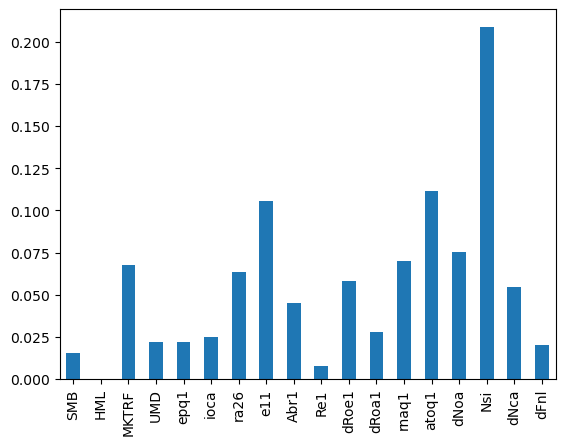

In [252]:
pd.Series(m.feature_importances_, index=model.x_test.columns).plot(kind="bar")

In [188]:
model.y_test

XRET_T1
monthid PERMNO          
456     10025   0.086949
        10026   0.066792
        10032  -0.010853
        10051   0.050073
        10104   0.065726
...                  ...
551     93397   0.143099
        93423   0.109565
        93426   0.076139
        93427   0.135751
        93436   0.243152

[240816 rows x 1 columns]

In [165]:
# data = pd.read_csv("assets.zip")

X = ml_data.dropna()[['SMB', 'HML', 'MKTRF', 'UMD', 'epq1', 'ioca', 'ra26', 'e11', 'Abr1', 'Re1', 'dRoe1', 'dRoa1', 'rnaq1', 'atoq1', 'dNoa', 'Nsi', 'dNca', 'dFnl']]
y = ml_data.dropna()['XRET_T1']

# this has lookahead bias, we just dropped NA (not ideal, instead should fill Na with cross sectional mean, then drop Na)
# X.fillna(X.mean(), inplace=True)
# y.fillna(y.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


Mean Squared Error: 0.015662521205462757


In [141]:
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                XRET_T1   R-squared (uncentered):                   0.740
Model:                            OLS   Adj. R-squared (uncentered):              0.740
Method:                 Least Squares   F-statistic:                          1.312e+05
Date:                Wed, 24 Apr 2024   Prob (F-statistic):                        0.00
Time:                        00:24:45   Log-Likelihood:                     -1.6239e+05
No. Observations:              829176   AIC:                                  3.248e+05
Df Residuals:                  829158   BIC:                                  3.250e+05
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
SMB            0.1162      0.002     64.353      0.000       0.113       0.120
HML            0.2254      0.001    182.576      0.000       0.223       0.228
MKTRF          0.0647      0.002     41.865      0.000       0.062       0.068
UMD           -0.0258      0.002    -13.234      0.000      -0.030      -0.022
epq1           0.1039      0.002     68.227      0.000       0.101       0.107
ioca           0.0856      0.002     50.318      0.000       0.082       0.089
ra26           0.0208      0.001     17.183      0.000       0.018       0.023
e11            0.0293      0.002     16.017      0.000       0.026       0.033
Abr1           0.0297      0.001     25.401      0.000       0.027       0.032
Re1            0.0143      0.001     10.621      0.000       0.012       0.017
dRoe1          0.0093      0.002      3.915      0.000       0.005       0.014
dRoa1          0.0031      0.002      1.280      0.201      -0.002       0.008
rnaq1          0.0915      0.001     63.434      0.000       0.089       0.094
atoq1          0.0501      0.001     36.636      0.000       0.047       0.053
dNoa          -0.0550      0.002    -34.953      0.000      -0.058      -0.052
Nsi            0.0052      0.002      2.682      0.007       0.001       0.009
dNca           0.1538      0.002     81.833      0.000       0.150       0.158
dFnl           0.0643      0.001     47.558      0.000       0.062       0.067
==============================================================================
Omnibus:                   293311.650   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39944.990
Skew:                          -0.008   Prob(JB):                         0.00
Kurtosis:                       1.925   Cond. No.                         21.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
data = pd.read_csv("assets.zip")

X = data[['SMB', 'HML', 'MKTRF', 'RF', 'UMD', 'monthid', 'epq1', 'ioca', 'ra26', 'e11', 'Re1', 'dRoe1', 'dRoa1', 'rnaq1', 'atoq1', 'dNoa', 'Nsi', 'dNca', 'dFnl']]
y = data['RET']

X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)


C:\Users\hughj\AppData\Local\Temp\ipykernel_16888\508038371.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


Mean Squared Error: 0.01380984620322806


   Feature  Coefficient  Absolute_Coefficient
0      SMB     0.004008              0.004008
11   rnaq1    -0.003496              0.003496
7      e11    -0.002590              0.002590
9    dRoe1    -0.001972              0.001972
15    dNca     0.001880              0.001880
6     ra26     0.001786              0.001786
14     Nsi    -0.001617              0.001617
8      Re1     0.001578              0.001578
13    dNoa     0.001410              0.001410
2    MKTRF    -0.001248              0.001248
10   dRoa1     0.001244              0.001244
5     ioca     0.000907              0.000907
3      UMD    -0.000841              0.000841
1      HML     0.000823              0.000823
16    dFnl     0.000685              0.000685
4     epq1    -0.000479              0.000479
12   atoq1     0.000420              0.000420


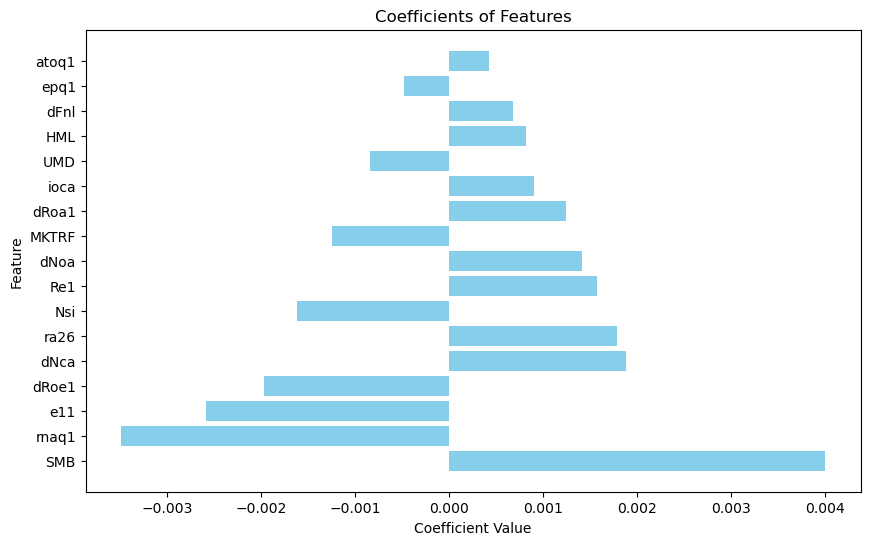

In [ ]:
coefficients = model.coef_

coefficients_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
coefficients_df['Absolute_Coefficient'] = abs(coefficients_df['Coefficient'])
sorted_coefficients_df = coefficients_df.sort_values(by='Absolute_Coefficient', ascending=False)

print(sorted_coefficients_df)

plt.figure(figsize=(10, 6))
plt.barh(sorted_coefficients_df['Feature'], sorted_coefficients_df['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Coefficients of Features')
plt.show()


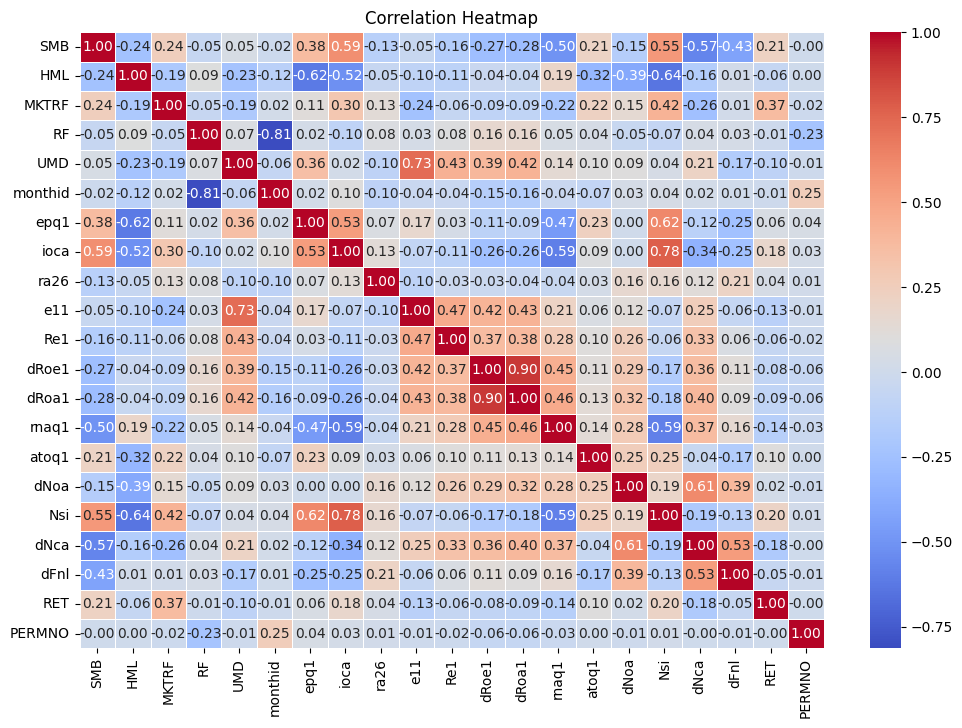

In [ ]:
cleaned = data.drop(columns=['DATEFF'])
correlation_matrix = cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
highest_correlation_pairs = correlation_matrix.unstack().sort_values(ascending=False)
highest_correlation_pairs = highest_correlation_pairs[highest_correlation_pairs != 1].drop_duplicates()

print(highest_correlation_pairs.head())

dRoa1  dRoe1    0.895938
ioca   Nsi      0.776612
UMD    e11      0.730722
Nsi    epq1     0.621109
dNoa   dNca     0.614551
dtype: float64
